<a href="https://colab.research.google.com/github/saincoder404/xeven_AI/blob/master/Classification_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Classification on Fashion Mnist using Pytorch**

You will Learn the following
1. Loading dataset
2. Preprocessing the dataset
3. Defination of Neural Network
4. Training a Neural Network
5. Testing a Neural Network

## **Loading the packages**

In [1]:
#importing required libraries..
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data.sampler import  SubsetRandomSampler  #for validation test
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


# **Load and Visualize the Data**

In [3]:
# Define a transform to convert images to tensors and normalize them
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,),)])  # mean and std have to be sequences (e.g., tuples),
                                                                      # therefore we should add a comma after the values

# Load the data: train and test sets
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data', download=True, train=False, transform=transform)

# Preparing for validation test
indices = list(range(len(trainset)))
np.random.shuffle(indices)

# To get 20% of the train set
split = int(np.floor(0.2 * len(trainset)))
train_sample = SubsetRandomSampler(indices[:split])
valid_sample = SubsetRandomSampler(indices[split:])


100%|██████████| 26421880/26421880 [00:13<00:00, 2023780.40it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 173189.59it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3259155.15it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6405303.17it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



In [4]:
#Data Loader
trainloader = torch.utils.data.DataLoader(trainset, sampler=train_sample, batch_size=64)
validloader = torch.utils.data.DataLoader(trainset, sampler=valid_sample, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [5]:
trainset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: /root/.pytorch/F_MNIST_data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

# **Visualize a Batch of Training Data**

In [6]:
trainloader

## **Visualize the data**

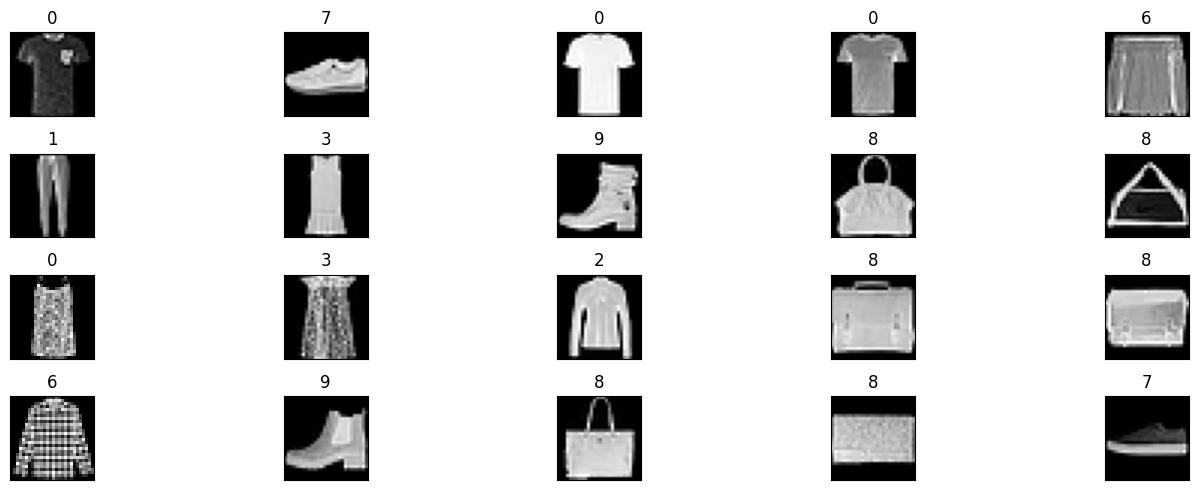

In [7]:
# Create an iterator for the trainloader
dataiter = iter(trainloader)
print(dataiter)

# Get the next batch of data (images and labels)
images, labels = next(dataiter)

# Create a figure to display the images
fig = plt.figure(figsize=(15, 5))

# Loop through the first 20 images in the batch
for idx in np.arange(20):
    # Create a subplot for each image
    # xticks=[], yticks=[] is empty to print the images without any ticks around them
    ax = fig.add_subplot(4, int(20/4), idx+1, xticks=[], yticks=[])

    # Display the image using a grayscale colormap
    ax.imshow(np.squeeze(images[idx]), cmap='gray')

    # Set the title of the subplot to the corresponding label
    # .item() gets the value contained in a Tensor
    ax.set_title(labels[idx].item())

# Ensure that the subplots are properly laid out within the figure
fig.tight_layout()


# **Define the Neural Network**

In [8]:
# Define a custom classifier class that inherits from nn.Module
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()

        # Define the layers of the neural network
        self.fc1 = nn.Linear(784, 120)  # Fully connected layer 1 with 784 input features and 120 output features
        self.fc2 = nn.Linear(120, 120)  # Fully connected layer 2 with 120 input features and 120 output features
        self.fc3 = nn.Linear(120, 10)   # Fully connected layer 3 with 120 input features and 10 output features
        self.dropout = nn.Dropout(0.2)  # Dropout layer with a dropout probability of 0.2

    def forward(self, x):
        # Reshape the input tensor to have a flat vector shape
        x = x.view(x.shape[0], -1)

        # Apply the first fully connected layer with ReLU activation and dropout
        x = self.dropout(F.relu(self.fc1(x)))

        # Apply the second fully connected layer with ReLU activation and dropout
        x = self.dropout(F.relu(self.fc2(x)))

        # Apply the third fully connected layer with log softmax activation
        x = F.log_softmax(self.fc3(x), dim=1)

        return x


## **Training the Model**

In [9]:
# Create an instance of the Classifier class to define the neural network model
model = Classifier()

# Define the loss function (Negative Log Likelihood Loss)
criterion = nn.NLLLoss()

# Define the optimizer (Stochastic Gradient Descent) and specify the learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Initialize a variable with a high value to track the minimum validation loss
valid_loss_min = np.Inf

# Set the number of training epochs
epochs = 20

# Initialize a variable to count training steps
steps = 0

# Put the model in training mode
model.train()

# Create empty lists to store training and validation losses
train_losses, valid_losses = [], []

# Loop through the specified number of epochs for training
for e in range(epochs):
    running_loss = 0
    valid_loss = 0

    # Train the model
    for images, labels in trainloader:
        optimizer.zero_grad()  # Clear the gradients
        log_ps = model(images)  # Forward pass
        loss = criterion(log_ps, labels)  # Calculate the loss
        loss.backward()  # Backpropagate the gradients
        optimizer.step()  # Update the weights
        running_loss += loss.item() * images.size(0)

    # Validate the model
    for images, labels in validloader:
        log_ps = model(images)  # Forward pass
        loss = criterion(log_ps, labels)  # Calculate the loss
        valid_loss += loss.item() * images.size(0)

    # Calculate average losses for training and validation
    running_loss = running_loss / len(trainloader.sampler)
    valid_loss = valid_loss / len(validloader.sampler)

    # Append the losses to their respective lists
    train_losses.append(running_loss)
    valid_losses.append(valid_loss)

    # Print training and validation loss for the current epoch
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        e+1,
        running_loss,
        valid_loss
    ))

    # Check if the current validation loss is lower than the minimum seen so far
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}). Saving Model ...'.format(valid_loss_min, valid_loss))
        torch.save(model.state_dict(), 'model.pt')  # Save the model's state
        valid_loss_min = valid_loss  # Update the minimum validation loss


Epoch: 1 	Training Loss: 1.930458 	Validation Loss: 1.445050
Validation loss decreased (inf --> 1.445050). Saving Model ...
Epoch: 2 	Training Loss: 1.170019 	Validation Loss: 0.989568
Validation loss decreased (1.445050 --> 0.989568). Saving Model ...
Epoch: 3 	Training Loss: 0.908098 	Validation Loss: 0.837095
Validation loss decreased (0.989568 --> 0.837095). Saving Model ...
Epoch: 4 	Training Loss: 0.804353 	Validation Loss: 0.763116
Validation loss decreased (0.837095 --> 0.763116). Saving Model ...
Epoch: 5 	Training Loss: 0.736457 	Validation Loss: 0.712910
Validation loss decreased (0.763116 --> 0.712910). Saving Model ...
Epoch: 6 	Training Loss: 0.697400 	Validation Loss: 0.683853
Validation loss decreased (0.712910 --> 0.683853). Saving Model ...
Epoch: 7 	Training Loss: 0.666841 	Validation Loss: 0.662045
Validation loss decreased (0.683853 --> 0.662045). Saving Model ...
Epoch: 8 	Training Loss: 0.640642 	Validation Loss: 0.635716
Validation loss decreased (0.662045 --> 0

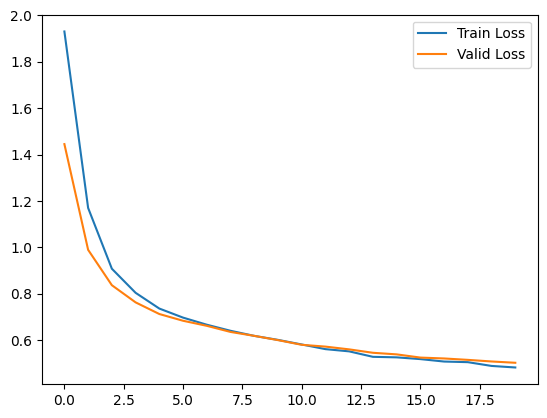

In [10]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')

plt.legend()

# **Load the Model with the Lowest Validation Loss**

In [11]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

# **Testing the model**

In [12]:
#track the test loss
test_loss = 0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))


model.eval()
for images, labels in testloader:
  #forword pass
  output = model(images)
  #calculate the loss
  loss = criterion(output, labels)
  #update the test loss
  test_loss += loss.item()*images.size(0)
  # convert output probabilities to predicted class
  _, pred = torch.max(output, 1)
  #compare predictions to the true labes
  correct = np.squeeze(pred.eq(labels.data.view_as(pred)))
  #calculate test accuracy for each object class
  for i in range(len(labels)):
    label = labels.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] +=1

#calcaulate and prınt test loss
test_loss = test_loss/len(testloader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
  if class_total[i] > 0:
    print('Test Accuracy of %5s: %2d%% (%2d/%2d)'%
          (str(i), 100 * class_correct[i]/class_total[i],
           np.sum(class_correct[i]), np.sum(class_total[i])))
  else:
    print('Test Accuracy of %5s: N/A(no training examples)' % classes[i])

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))



Test Loss: 0.482828

Test Accuracy of     0: 78% (783/1000)
Test Accuracy of     1: 94% (947/1000)
Test Accuracy of     2: 71% (719/1000)
Test Accuracy of     3: 85% (856/1000)
Test Accuracy of     4: 80% (808/1000)
Test Accuracy of     5: 90% (900/1000)
Test Accuracy of     6: 45% (455/1000)
Test Accuracy of     7: 88% (881/1000)
Test Accuracy of     8: 94% (949/1000)
Test Accuracy of     9: 92% (928/1000)

Test Accuracy (Overall): 82% (8226/10000)


* 0: T-shirt/Top
* 1: Trouser
* 2: PullOver
* 3: Dress
* 4: Coat
* 5: Sandal
* 6: Shirt
* 7: Sneaker
* 8: Bag
* 9: Ankle Bot

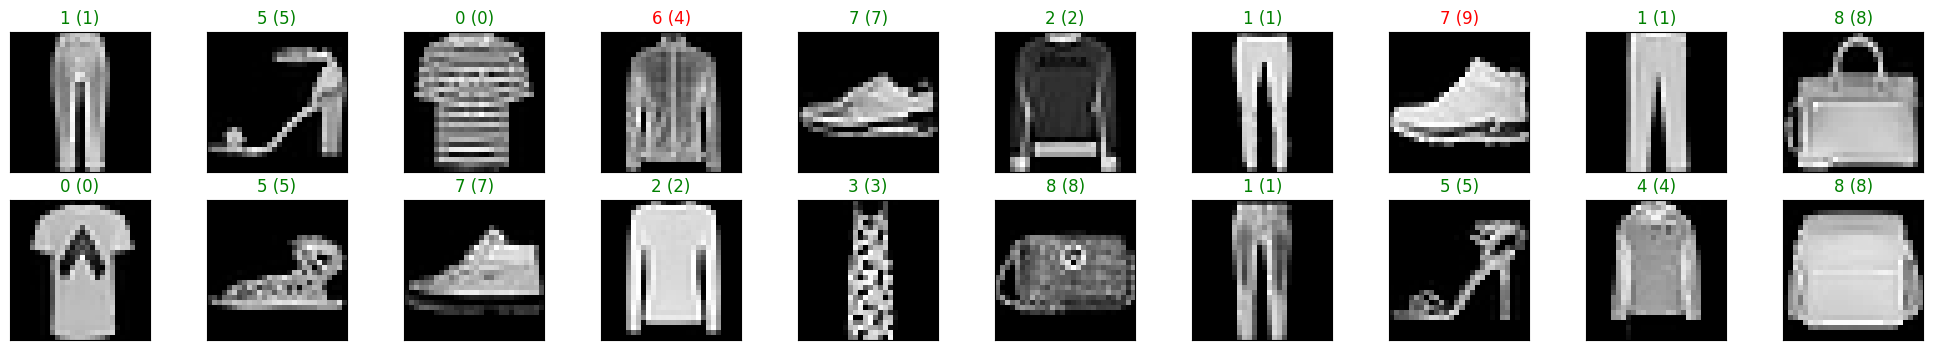

In [13]:
# obtain one batch of test images
dataiter = iter(testloader)
images, labels = next(dataiter)

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))